<a href="https://colab.research.google.com/github/OptimizationExpert/Pyomo/blob/main/CVRPTW_CP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Developed by Alireza Soroudi
alireza.soroudi@gmail.com

Linkedin News letter : https://www.linkedin.com/newsletters/optimization-in-open-source-6874020019009859585/

Git hub: https://github.com/OptimizationExpert/Pyomo

In [8]:
import pandas as pd
!pip install ortools
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt # Data visualization
import random
import numpy as np
import time

384


{1: (0.5, 0.5, 0),
 2: (0.8964113819262561, 0.27424792193806946, 7),
 3: (0.9578847582905333, 0.0017566274843920926, 9),
 4: (0.5795714102937845, 0.7716643628074372, 19),
 5: (0.21088312720700375, 0.5864742110716747, 10),
 6: (0.016120163861390813, 0.19492598386547866, 4),
 7: (0.022837663319748236, 0.1350338334732094, 2),
 8: (0.3763973342676973, 0.8114433945350511, 11),
 9: (0.004493763966467057, 0.35297255731207877, 17),
 10: (0.9086786935664859, 0.8666499087456587, 1),
 11: (0.3385274367310961, 0.4522239507911292, 7),
 12: (0.2698722867216262, 0.24386632340023384, 9),
 13: (0.027753757422824377, 0.29143099156319785, 3),
 14: (0.45343911644679913, 0.9928244282490835, 1),
 15: (0.31576496008447585, 0.04947507988876265, 2),
 16: (0.9805157974819251, 0.7914105088289098, 11),
 17: (0.16534922192009793, 0.9246389216149707, 9),
 18: (0.0031660680902272365, 0.7301978428897974, 13),
 19: (0.11301444762889579, 0.5311846778308648, 1),
 20: (0.5881492096341668, 0.45071129044437463, 6),
 21: (0

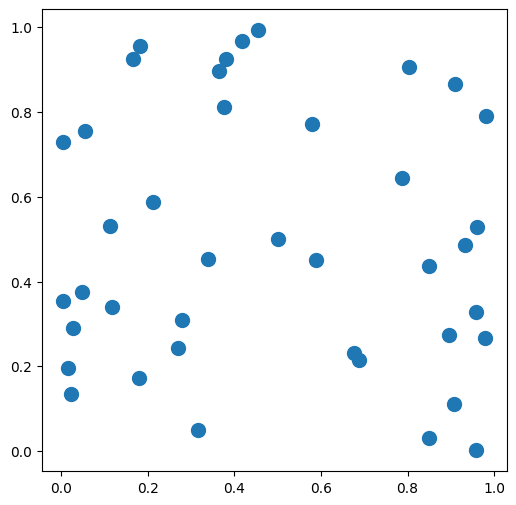

In [3]:
n = 40
depot = 1
nodes = [i for i in range(1,1+n)]
data = {}
for n in nodes:
  data[n]=(random.random(),random.random(), random.randint(1,20))
data[depot]=(0.5, 0.5,0)
plt.figure(figsize=(6,6))
X= [data[n][0] for n in nodes]
Y= [data[n][1] for n in nodes]
plt.scatter(X,Y,s=100)
total_load = sum(data[n][2] for n in nodes)
print(total_load)
data

In [4]:
def distance(n:int,m:int,data:dict)-> int:
  x1,y1 = data[n][0],data[n][1]
  x2,y2 = data[m][0],data[m][1]
  return int(100*np.sqrt( (x1-x2)**2+(y1-y2)**2))

distance(1,2,data)

check = sum(data[n][2] for n in nodes)

KOLORS = ['r','k','b','g','orange','gold']


window = {}

for i in nodes:
  st = 60*random.randint(5,9)
  L = 30*random.randint(2,7)
  st2 = 60*random.randint(12,17)
  L2 = 30*random.randint(3,6)
  window[i]= {'w1':(st,st+L), 'w2':(st2,st2+L2)}


all_dists = [distance(n,m,data) for n in nodes for m in nodes if n>m]
print(min(all_dists), max(all_dists))
max_d = max(all_dists)
max_d

1 123


123

In [50]:
cap = {0:120, 1:190, 2:150, 3:170, 4:150, 5:160}
cars = cap.keys()
possible_windpws = ['w1','w2']

def main() -> None:
    # Creates the model.

    model = cp_model.CpModel()
    x={(i,j,c):model.NewBoolVar(f"flow_{i}_{j}_{c}") for i in nodes
       for j in nodes for c in cars if i!=j and distance(i,j,data)<max_d/2}
    assign = {(i,c): model.NewBoolVar(f"assign_{i}_{c}") for i in nodes for c in cars}
    used_car = {c: model.NewBoolVar(f"used_{c}") for c in cars}
    arrive = {i: model.NewIntVar(0,1500,f"arrive_{i}") for i in nodes}

    assign_window = {(i,w): model.NewBoolVar(f"window_{i}_{w}") for i in nodes for w in possible_windpws}
    start_car = {c: model.NewIntVar(0,1000,f"start_car_{c}") for c in cars}
    duration_car = {c: model.NewIntVar(0,500,f"finish_car_{c}") for c in cars}

    for i in nodes:

      if i!=depot:
        expressions = [assign[i,c] for c in cars]
        model.AddExactlyOne(expressions)
      else:
        for c in cars:
          model.Add(assign[i,c]==used_car[c])

      expr_window= [assign_window[i,w] for w in possible_windpws]
      model.AddExactlyOne(expr_window)
      for w in possible_windpws:
        if i!=depot:
          model.Add(arrive[i]>=window[i][w][0]).OnlyEnforceIf(assign_window[i,w])
          model.Add(arrive[i]<=window[i][w][1]).OnlyEnforceIf(assign_window[i,w])


    for (i,c),v in assign.items():
      model.Add(v<=used_car[c])

    for (i,j,c),v in x.items():
      if distance(i,j,data)>max_d/2:
        model.Add(v==0)
      model.Add(v==0).OnlyEnforceIf(assign[i,c].Not())
      model.Add(v==0).OnlyEnforceIf(assign[j,c].Not())
      model.Add(v==0).OnlyEnforceIf(used_car[c].Not())

      speed = 0.5
      if j==depot:
        model.Add(start_car[c] + duration_car[c]==arrive[i]+int(speed*distance(i,j,data)) ).OnlyEnforceIf(v)
      elif i==depot:
        model.Add(arrive[j]==start_car[c]+int(speed*distance(i,j,data)) ).OnlyEnforceIf(v)
      else:
        model.Add(arrive[j]>=arrive[i]+int(speed*distance(i,j,data)) ).OnlyEnforceIf(v)


    for c in cars:
      #model.Add(finish_car[c] - start_car[c]<= 480).OnlyEnforceIf(used_car[c])
      #model.Add(sum(assign[i,c] for i in nodes)<= int(len(nodes)/len(cars)) + 5)
      model.Add(duration_car[c] == 0).OnlyEnforceIf(used_car[c].Not())
      model.Add(start_car[c] == 0).OnlyEnforceIf(used_car[c].Not())


      arcs= [ (i,j,v) for (i,j,cc),v in x.items() if cc == c] + [(i,i,assign[i,c].Not()) for i in nodes]
      model.AddCircuit(arcs)

      expressions = [v for (i,cc),v in assign.items() if c ==cc]
      coeffs = [data[i][2] for (i,cc),v in assign.items() if c ==cc]

      model.Add(cp_model.LinearExpr.WeightedSum(expressions, coeffs) <= cap[c]*used_car[c])


    for c1 in cars:
      for c2 in cars:
        if cap[c1]<cap[c2]:
          pass
          #model.Add( duration_car[c1] - (1-used_car[c1])*1000 < duration_car[c2] + (1-used_car[c2])*1000)
    #expressions_of = [ v for (i,j,c),v in x.items() ]
    #coeffs_of = [distance(i,j,data) for (i,j,c),v in x.items() ]
    #model.minimize(cp_model.LinearExpr.WeightedSum(expressions_of,coeffs_of))

    expressions_of = [ duration_car[c] for c in cars ]
    model.Minimize(cp_model.LinearExpr.Sum(expressions_of))

    # Creates a solver and solves the model.
    for c in cars:
      model.AddHint(used_car[c],1)

    solver = cp_model.CpSolver()
    solver.parameters.subsolvers[:] = ['core', 'pseudo_costs', 'no_lp']
    solver.parameters.max_time_in_seconds = 600
    solver.parameters.num_search_workers = 4
    status = solver.solve(model)
    print(solver.StatusName(status))
    print(solver.ObjectiveValue(), solver.BestObjectiveBound())

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        return solver,x, assign, used_car, start_car, duration_car, arrive

    else:
        print("No solution found.")


if __name__ == "__main__":
  st= time.time()
  solver, x,assign, used_car, start_car, duration_car, arrive = main()
  print("Time ", time.time()-st)

  print(f"Min of objective function: {solver.objective_value}\n")




FEASIBLE
588.0 0.0
Time  601.1725721359253
Min of objective function: 588.0



TAG800 0 0 0 0 0
TAG800 1 20 1 282 285
TAG800 2 0 0 0 0
TAG800 3 0 0 0 0
TAG800 4 11 1 820 126
TAG800 5 11 1 454 177
Tag600 1 5
Tag600 1 24
Tag600 1 39
Tag600 2 1
Tag600 3 2
Tag600 4 14
Tag600 5 25
Tag600 6 7
Tag600 7 15
Tag600 8 36
Tag600 9 23
Tag600 10 1
Tag600 11 34
Tag600 12 27
Tag600 13 9
Tag600 14 8
Tag600 15 28
Tag600 16 29
Tag600 17 37
Tag600 18 1
Tag600 19 18
Tag600 20 21
Tag600 21 3
Tag600 22 10
Tag600 23 11
Tag600 24 12
Tag600 25 17
Tag600 26 31
Tag600 27 13
Tag600 28 26
Tag600 29 40
Tag600 30 16
Tag600 31 30
Tag600 32 6
Tag600 33 38
Tag600 34 22
Tag600 35 32
Tag600 36 19
Tag600 37 33
Tag600 38 20
Tag600 39 35
Tag600 40 4


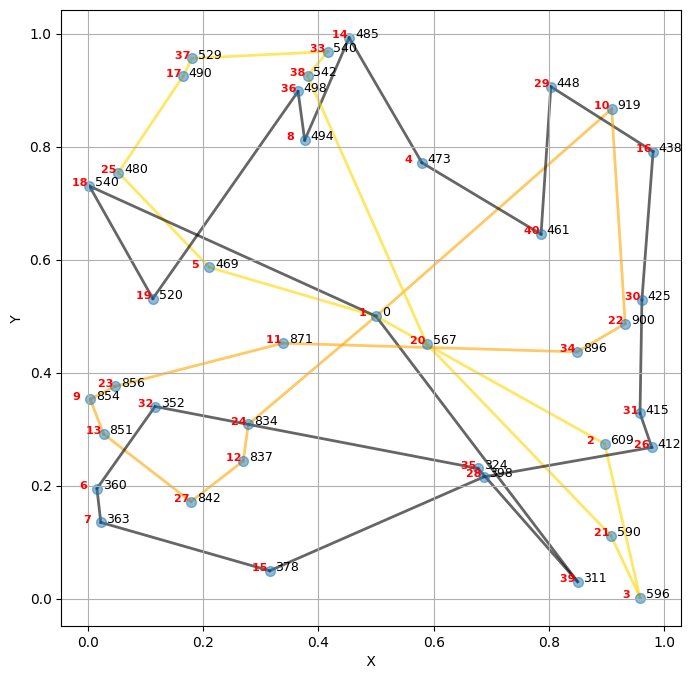

In [79]:
plt.figure(figsize=(8,8))
X= [data[n][0] for n in nodes]
Y= [data[n][1] for n in nodes]
plt.scatter(X,Y,s=50, alpha =0.5)

for c in cars:
  n = sum(solver.Value(assign[i,c]) for i in nodes)
  print("TAG800",c,n,solver.Value(used_car[c]), solver.Value(start_car[c]),solver.Value(duration_car[c]) )

for i in nodes:
  car_assigned = sum(c*solver.Value(assign[i,c]) for c in cars)
  #print("TAG900",i,solver.Value(arrive[i]),car_assigned)
  plt.text(data[i][0]-0.03,data[i][1],s=f"{i} " , fontsize=8, fontweight='bold',c='r')
  plt.text(data[i][0]+0.01,data[i][1],s=str(solver.Value(arrive[i])) , fontsize=9)

for (i,j,c),v in x.items():
  if solver.value(v)>0:
      x1,y1 = data[i][0],data[i][1]
      x2,y2 = data[j][0],data[j][1]
      plt.plot([x1,x2],[y1,y2], lw=2, c=KOLORS[c], alpha=0.6, zorder = -2)
      print("Tag600",i,j)

plt.xlabel(' X ')
plt.ylabel(' Y ')
plt.grid()

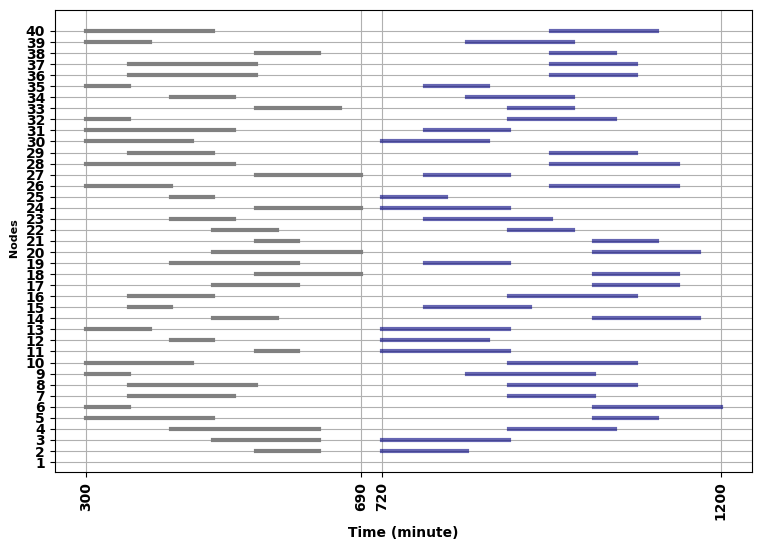

In [80]:
plt.figure(figsize=(9,6))
w1_list, w2_list = [], []
for n in window:
  if n >1:
    av = solver.Value(arrive[n])
    st,fn = window[n]['w1'][0],window[n]['w1'][1]
    plt.plot([st,fn],[n,n],lw=3,c='grey')
    w1_list +=[st,fn]
    st,fn = window[n]['w2'][0],window[n]['w2'][1]
    plt.plot([st,fn],[n,n],lw=3,c='navy',alpha=0.6)
    w2_list +=[st,fn]
    #plt.scatter(av,n,s=30,c='r', zorder = 2)


plt.grid()
plt.xticks([min(w1_list),max(w1_list),min(w2_list),max(w2_list)], rotation =90, fontweight='bold')
plt.yticks(nodes, rotation =0, fontweight='bold')
plt.xlabel(' Time (minute) ', fontweight='bold')
plt.ylabel(' Nodes', fontweight='bold', fontsize = 8)
plt.show()
